In [3]:
# Script developed by Cíntia Eleutério (2025)

import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dropout, Dense, concatenate
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

# Dictionary with gauging stations and their corresponding CSV files
stations = {
    "Caracarai": "caracaraí_seca.csv",
    "Cucuí": "cucuí_seca.csv",
    "Moura": "moura_seca.csv",
    "Santa_Maria_do_Boiacu": "santa_maria_do_boiaçú_seca.csv",
    "Serrinha": "serrinha_seca.csv"
}

# Subnet hyperparameter configurations (can be tuned individually for each station)
subnet_config = {
    "Caracarai": {"filters": 64, "kernel_size": 4, "pool_size": 2, "dropout_rate": 0.5},
    "Cucuí": {"filters": 64, "kernel_size": 4, "pool_size": 2, "dropout_rate": 0.5},
    "Moura": {"filters": 32, "kernel_size": 4, "pool_size": 2, "dropout_rate": 0.5},
    "Santa_Maria_do_Boiacu": {"filters": 32, "kernel_size": 4, "pool_size": 2, "dropout_rate": 0.5},
    "Serrinha": {"filters": 32, "kernel_size": 4, "pool_size": 2, "dropout_rate": 0.5},
}

def create_subnet(input_layer, filters, kernel_size, pool_size, dropout_rate):
    """
    Builds a subnet for one station using Conv1D layers, pooling and dropout.
    """
    x = Conv1D(filters=filters, kernel_size=min(kernel_size, input_layer.shape[1]),
               activation='relu', padding='same')(input_layer)
    x = Conv1D(filters=filters * 2, kernel_size=min(kernel_size, input_layer.shape[1]),
               activation='relu', padding='same')(x)
    x = MaxPooling1D(pool_size=min(pool_size, input_layer.shape[1]))(x)
    x = Dropout(dropout_rate)(x)
    x = Conv1D(filters=filters, kernel_size=min(kernel_size, x.shape[1]),
               activation='relu', padding='same')(x)
    x = MaxPooling1D(pool_size=min(pool_size, x.shape[1]))(x)
    x = Dropout(dropout_rate)(x)
    x = Flatten()(x)
    return x

def process_data(file_path):
    """
    Reads a CSV file for one station, scales the data and prepares it for CNN input.
    """
    df = pd.read_csv(file_path)

    # Select last 10 years (input) and target year (output)
    X = df.iloc[:, -18:-8].values / 100   # Inputs: previous 10 hydrological years
    Y = df.iloc[:, -8].values / 100       # Target: reference dry year (e.g., 2015/2016)

    # Normalize input and output
    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()
    X = scaler_x.fit_transform(X)
    Y = scaler_y.fit_transform(Y.reshape(-1, 1))

    # Reshape for Conv1D input: (samples, timesteps, features)
    X = X.reshape(X.shape[0], X.shape[1], 1)
    return X, Y, scaler_y

# Preprocess all stations
station_data = {station: process_data(file) for station, file in stations.items()}

# Create subnet inputs for each station
inputs = {}
subnets = {}
for station, config in subnet_config.items():
    input_layer = Input(shape=(10, 1), name=f"input_{station}")
    subnet = create_subnet(input_layer, **config)
    inputs[station] = input_layer
    subnets[station] = subnet

# Merge all subnet outputs
merged = concatenate(list(subnets.values()), name="merged_layer")

# Fully connected layers after concatenation
dense_1 = Dense(60, activation='relu', kernel_regularizer=l2(0.05))(merged)
dense_2 = Dense(30, activation='relu', kernel_regularizer=l2(0.05))(dense_1)
output = Dense(1, name="output_layer")(dense_2)

# Build the full model
model = Model(inputs=list(inputs.values()), outputs=output)
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='mean_squared_error',
              metrics=['mae'])

# Combine data from all stations for training/validation
X_train = np.concatenate([station_data[station][0] for station in stations], axis=0)
Y_train = np.concatenate([station_data[station][1] for station in stations], axis=0)

# Train/validation split (80/20)
split_idx = int(0.8 * X_train.shape[0])
X_val, Y_val = X_train[split_idx:], Y_train[split_idx:]
X_train, Y_train = X_train[:split_idx], Y_train[:split_idx]

# Adjust data for multi-input model (same data is fed to all station inputs)
X_train_all_stations = [X_train for _ in stations]
X_val_all_stations = [X_val for _ in stations]

# Train model
history = model.fit(X_train_all_stations, Y_train,
                    epochs=200,
                    validation_data=(X_val_all_stations, Y_val),
                    verbose=1)

# Predictions and saving outputs per station
for station in stations:
    X_test, Y_test, scaler_y = station_data[station]
    predictions = model.predict([X_test for _ in stations])
    predictions_rescaled = scaler_y.inverse_transform(predictions)

    Y_real_rescaled = scaler_y.inverse_transform(Y_test)

    # Save observed vs predicted values
    output_df = pd.DataFrame({
        "Observed": Y_real_rescaled.flatten(),
        "Predicted": predictions_rescaled.flatten()
    })
    output_df.to_csv(f"{station}_predictions_dry.csv", index=False)
    print(f"File {station}_predictions_dry.csv saved successfully!")


Epoch 1/200


/home/carlos/.local/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_Caracarai', 'input_Cucuí', 'input_Moura', 'input_Santa_Maria_do_Boiacu', 'input_Serrinha']. Received: the structure of inputs=('*', '*', '*', '*', '*')
  warnings.warn(


46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 5.7768 - mae: 0.1716 - val_loss: 2.4287 - val_mae: 0.1568
Epoch 2/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.8956 - mae: 0.0930 - val_loss: 0.8697 - val_mae: 0.1154
Epoch 3/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7106 - mae: 0.0894 - val_loss: 0.3911 - val_mae: 0.1318
Epoch 4/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.3232 - mae: 0.0803 - val_loss: 0.1942 - val_mae: 0.1030
Epoch 5/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1674 - mae: 0.0873 - val_loss: 0.1193 - val_mae: 0.1536
Epoch 6/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0904 - mae: 0.0863 - val_loss: 0.0559 - val_mae: 0.0803
Epoch 7/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0524 - mae: 0.0861 - val_loss: 0.0346 - val_mae: 0.0921
Epoch 8/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0320 - mae: 0.0804 - val_loss: 0.0255 - val_mae: 0.1012
Epoch 9/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0217 - mae: 

Epoch 55/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0076 - mae: 0.0534 - val_loss: 0.0130 - val_mae: 0.0919
Epoch 56/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0063 - mae: 0.0471 - val_loss: 0.0122 - val_mae: 0.0889
Epoch 57/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0069 - mae: 0.0516 - val_loss: 0.0090 - val_mae: 0.0712
Epoch 58/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0067 - mae: 0.0509 - val_loss: 0.0095 - val_mae: 0.0736
Epoch 59/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0064 - mae: 0.0502 - val_loss: 0.0090 - val_mae: 0.0694
Epoch 60/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0070 - mae: 0.0498 - val_loss: 0.0101 - val_mae: 0.0745
Epoch 61/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0066 - mae: 0.0487 - val_loss: 0.0085 - val_mae: 0.0651
Epoch 62/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0071 - mae: 0.0491 - val_loss: 0.0095 - val_mae: 0.0728
Epoch 63/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step 

Epoch 109/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0051 - mae: 0.0421 - val_loss: 0.0091 - val_mae: 0.0720
Epoch 110/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0042 - mae: 0.0388 - val_loss: 0.0109 - val_mae: 0.0815
Epoch 111/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0045 - mae: 0.0399 - val_loss: 0.0084 - val_mae: 0.0656
Epoch 112/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0046 - mae: 0.0397 - val_loss: 0.0110 - val_mae: 0.0814
Epoch 113/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0043 - mae: 0.0393 - val_loss: 0.0076 - val_mae: 0.0654
Epoch 114/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0045 - mae: 0.0395 - val_loss: 0.0092 - val_mae: 0.0723
Epoch 115/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0057 - mae: 0.0460 - val_loss: 0.0094 - val_mae: 0.0693
Epoch 116/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0068 - mae: 0.0488 - val_loss: 0.0087 - val_mae: 0.0682
Epoch 117/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


/tmp/ipykernel_20337/3305042315.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


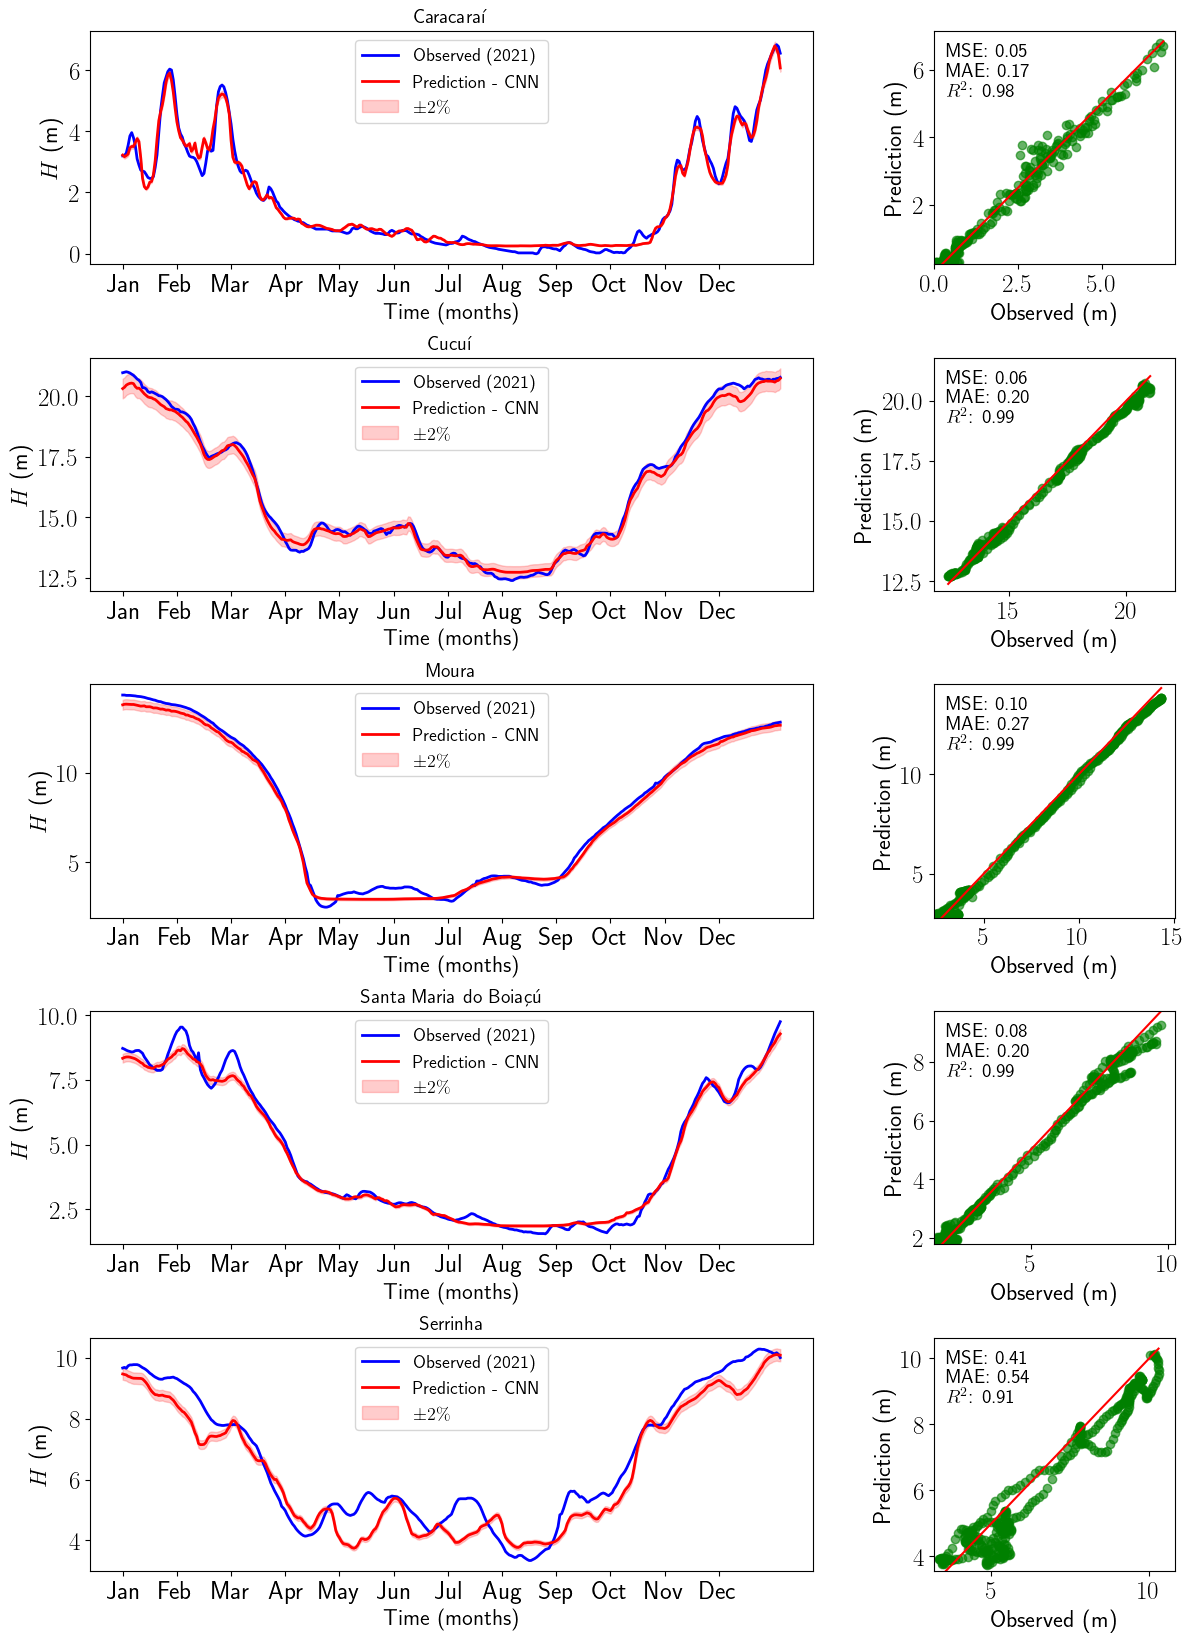

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Global plot settings (LaTeX for text rendering, font sizes, etc.)
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 15})
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['legend.fontsize'] = 16

# Subplots: for each station, create 2 columns (time series on the left, scatter on the right)
n_stations = len(stations)
fig, axs = plt.subplots(
    n_stations, 2,
    figsize=(14, n_stations * 4),
    gridspec_kw={'width_ratios': [3, 1], 'wspace': 0.25, 'hspace': 0.4}
)

# Define month labels for the x-axis
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Loop over stations to create plots
for i, station in enumerate(stations.keys()):
    # Retrieve test data for this station
    X_test, Y_test, scaler_y = station_data[station]

    # Predictions for the test set
    predictions = model.predict([X_test for _ in stations])
    predictions_rescaled = scaler_y.inverse_transform(predictions)
    Y_real_rescaled = scaler_y.inverse_transform(Y_test)

    # Error metrics
    mse = mean_squared_error(Y_real_rescaled, predictions_rescaled)
    mae = mean_absolute_error(Y_real_rescaled, predictions_rescaled)
    rmse = np.sqrt(mse)  
    r2 = r2_score(Y_real_rescaled, predictions_rescaled)  

    # ±2% prediction uncertainty band
    lower_bound = predictions_rescaled[:365] * 0.98
    upper_bound = predictions_rescaled[:365] * 1.02

    # ---- Left plot: Time series comparison ----
    axs[i, 0].plot(Y_real_rescaled[:365], label="Observed (2021)", color='blue', linewidth=2)
    axs[i, 0].plot(predictions_rescaled[:365], label="Prediction - CNN", color='red', linestyle='-', linewidth=2)
    axs[i, 0].fill_between(range(365), lower_bound.flatten(), upper_bound.flatten(),
                           color='red', alpha=0.2, label="$\pm 2\%$")

    # Station-specific titles
    axs[0, 0].set_title("Caracaraí", fontsize=14)
    axs[1, 0].set_title("Cucuí", fontsize=14)
    axs[2, 0].set_title("Moura", fontsize=14)
    axs[3, 0].set_title("Santa Maria do Boiaçú", fontsize=14)
    axs[4, 0].set_title("Serrinha", fontsize=14)

    axs[i, 0].set_xlabel("Time (months)", fontsize=16)
    axs[i, 0].set_ylabel("$H$ (m)", fontsize=17)
    axs[i, 0].set_xticks([j * 30 for j in range(12)])
    axs[i, 0].set_xticklabels(months, fontsize=18)
    axs[i, 0].legend(fontsize=13)

    # ---- Right plot: Scatter comparison ----
    axs[i, 1].scatter(Y_real_rescaled, predictions_rescaled, alpha=0.6, color='green')
    axs[i, 1].plot([Y_real_rescaled.min(), Y_real_rescaled.max()],
                   [Y_real_rescaled.min(), Y_real_rescaled.max()],
                   color='red', linestyle='-')
    axs[i, 1].set_xlabel("Observed (m)", fontsize=17)
    axs[i, 1].set_ylabel("Prediction (m)", fontsize=17)

    # Set scatter plot limits with margin
    axs[i, 1].set_xlim(Y_real_rescaled.min() * 0.95, Y_real_rescaled.max() * 1.05)
    axs[i, 1].set_ylim(predictions_rescaled.min() * 0.95, predictions_rescaled.max() * 1.05)

    # Add error metrics inside the scatter plot
    axs[i, 1].text(0.05, 0.95,
                   f"MSE: {mse:.2f}\nMAE: {mae:.2f}\n$R^2$: {r2:.2f}",
                   transform=axs[i, 1].transAxes,
                   fontsize=14, verticalalignment='top', color='black')

# Adjust layout and save figure
plt.tight_layout()
plt.savefig("prediction_individual_ranges_dry.pdf", format="pdf", bbox_inches="tight")
plt.show()
